# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
class MyBinaryLogisticRegression:
    def __init__(
        self,
        lr=0.1,
        n_iters=1000,
        reg_type=None,      # None | 'l1' | 'l2' | 'l1l2'
        l1_coef=0.0,
        l2_coef=0.0,
        optimizer='gd',     # 'gd' | 'sgd' | 'newton'
        batch_size=32
    ):
        self.lr = lr
        self.n_iters = n_iters
        self.reg_type = reg_type
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.coefs_ = None
        self.feature_names_in_ = None

    def _gradient(self, X, y):
        n = X.shape[0]
        y_pred = sigmoid(X @ self.coefs_)
        grad = X.T @ (y_pred - y) / n

        if self.reg_type in ['l1', 'l1l2']:
            grad += self.l1_coef * np.sign(self.coefs_)
        if self.reg_type in ['l2', 'l1l2']:
            grad += 2 * self.l2_coef * self.coefs_

        return grad
    
    def _hessian(self, X):
        p = sigmoid(X @ self.coefs_)
        S = np.diag(p * (1 - p))
        H = X.T @ S @ X / X.shape[0]

        if self.reg_type == 'l2':
            H += 2 * self.l2_coef * np.eye(X.shape[1])

        return H

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.feature_names_in_ = X.columns
        X = np.c_[np.ones(X.shape[0]), X.values]
        y = y.values
        self.coefs_ = np.zeros(X.shape[1])

        for _ in range(self.n_iters):
            if self.optimizer == 'gd':
                grad = self._gradient(X, y)
                self.coefs_ -= self.lr * grad

            elif self.optimizer == 'sgd':
                idx = np.random.choice(X.shape[0], self.batch_size)
                grad = self._gradient(X[idx], y[idx])
                self.coefs_ -= self.lr * grad

            elif self.optimizer == 'newton':
                if self.reg_type != 'l2':
                    raise ValueError("Newton method applicable only for L2 regularization")
                grad = self._gradient(X, y)
                H = self._hessian(X)
                self.coefs_ -= np.linalg.inv(H) @ grad

        return self

    def predict(self, X: pd.DataFrame):
        X = np.c_[np.ones(X.shape[0]), X.values]
        probs = sigmoid(X @ self.coefs_)
        return (probs >= 0.5).astype(int)

    def score(self, X: pd.DataFrame, y: pd.Series):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [4]:
class TargetEncoder:
    def fit(self, X, y):
        self.mapping_ = y.groupby(X).mean()
        self.global_mean_ = y.mean()
        return self

    def transform(self, X):
        return X.map(self.mapping_).fillna(self.global_mean_)

### Загрузка данных

In [18]:
df = pd.read_csv("penguins_binary_classification.csv")

# оставляем только два класса
df = df[df['species'].isin(['Adelie', 'Gentoo'])].reset_index(drop=True)

# бинарный таргет
y = df['species'].map({'Adelie': 0, 'Gentoo': 1})

# признаки
X = df.drop(columns='species')


### One-hot

In [19]:
X_ohe = pd.get_dummies(X, columns=['island'], drop_first=True)
X_ohe = X_ohe.astype(float)

### Target Encoder

In [20]:
te = TargetEncoder()
X_te = X.copy()
X_te['island'] = te.fit(X['island'], y).transform(X['island'])
X_te = X_te.astype(float)

### Результаты

In [40]:
results = []

configs = [
    ('l2', 'gd'),
    ('l2', 'newton'),
    ('l1', 'gd'),
    ('l1l2', 'sgd')
]

# ONE-HOT
for reg, opt in configs:
    model = MyBinaryLogisticRegression(
        reg_type=reg,
        l1_coef=0.01,
        l2_coef=0.01,
        optimizer=opt,
        n_iters=500
    )
    model.fit(X_ohe, y)
    f1 = model.score(X_ohe, y)

    results.append({
        'encoding': 'one-hot',
        'regularization': reg,
        'optimizer': opt,
        'f1': f1
    })

# TARGET ENCODING
for reg, opt in configs:
    model = MyBinaryLogisticRegression(
        reg_type=reg,
        l1_coef=0.01,
        l2_coef=0.01,
        optimizer=opt,
        n_iters=500
    )
    model.fit(X_te, y)
    f1 = model.score(X_te, y)

    results.append({
        'encoding': 'target',
        'regularization': reg,
        'optimizer': opt,
        'f1': f1
    })

df_results = pd.DataFrame(results)
df_results

C:\Users\nikgr\AppData\Local\Temp\ipykernel_3856\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\nikgr\AppData\Local\Temp\ipykernel_3856\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\nikgr\AppData\Local\Temp\ipykernel_3856\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\nikgr\AppData\Local\Temp\ipykernel_3856\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\nikgr\AppData\Local\Temp\ipykernel_3856\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\nikgr\AppData\Local\Temp\ipykernel_3856\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


,encoding,regularization,optimizer,f1
0,one-hot,l2,gd,0.770000
1,one-hot,l2,newton,1.000000
2,one-hot,l1,gd,0.855856
3,one-hot,l1l2,sgd,0.694915
4,target,l2,gd,0.830189
5,target,l2,newton,1.000000
6,target,l1,gd,0.855856
7,target,l1l2,sgd,0.897119


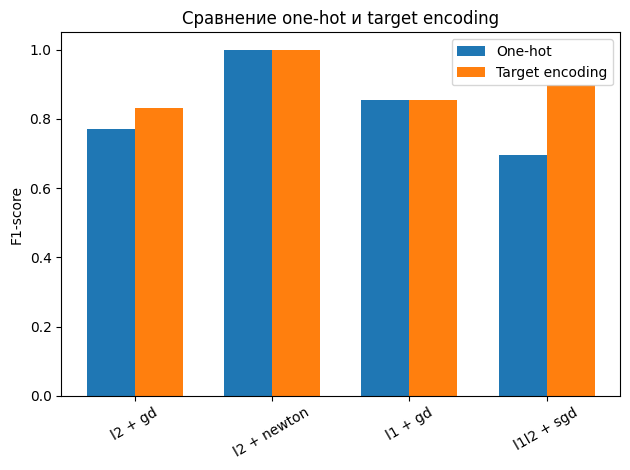

In [41]:
import matplotlib.pyplot as plt

labels = []
f1_onehot = []
f1_target = []

for reg, opt in configs:
    label = f"{reg} + {opt}"
    labels.append(label)

    f1_onehot.append(
        df_results.query(
            "encoding == 'one-hot' and regularization == @reg and optimizer == @opt"
        )['f1'].values[0]
    )

    f1_target.append(
        df_results.query(
            "encoding == 'target' and regularization == @reg and optimizer == @opt"
        )['f1'].values[0]
    )

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, f1_onehot, width, label='One-hot')
plt.bar(x + width/2, f1_target, width, label='Target encoding')

plt.xticks(x, labels, rotation=30)
plt.ylabel('F1-score')
plt.title('Сравнение one-hot и target encoding')
plt.legend()
plt.tight_layout()
plt.show()


# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

## Решение

Дана обучающая выборка
$$
(x_i, y_i), \quad y_i \in \{1, \ldots, M\}, \quad i \in \{1, \ldots, N\},
$$
где $x_i \in \mathbb{R}^d$ — вектор признаков объекта. Предполагается, что первая координата каждого вектора равна $1$, что соответствует свободному члену (bias).

Используя `softmax`-подход, дискриминативная модель имеет вид:
$$
\mathbb P(C_k \mid x)
=
\frac{\exp(\omega_k^T x)}
{\sum_{j=1}^{M} \exp(\omega_j^T x)},
$$
где $\omega_k \in \mathbb{R}^d$ — вектор параметров, соответствующий классу $C_k$.

---

### One-hot кодирование меток классов

Для удобства записи правдоподобия выполним one-hot кодирование меток классов.

Каждому объекту $x_i$ сопоставляется вектор
$$
\widehat y_i = (y_{i1}, \ldots, y_{iM}),
$$
где
$$
y_{ij} =
\begin{cases}
1, & j = y_i, \\
0, & j \neq y_i.
\end{cases}
$$

Таким образом, вектор $\widehat y_i$ состоит из нулей и ровно одной единицы, соответствующей истинному классу объекта.

---

### Функция правдоподобия

Правдоподобие всей обучающей выборки при заданных параметрах $\omega$ имеет вид:
$$
\mathbb P(D \mid \omega)
=
\prod_{i=1}^{N}
\prod_{j=1}^{M}
\mathbb P(C_j \mid x_i)^{y_{ij}}.
$$

Перейдём к логарифму правдоподобия:
$$
\log \mathbb P(D \mid \omega)
=
\sum_{i=1}^{N}
\sum_{j=1}^{M}
y_{ij} \log \mathbb P(C_j \mid x_i).
$$

---

### Функция потерь

В качестве функции потерь используется отрицательное логарифмическое правдоподобие:
$$
\mathcal L(\omega)
=
- \sum_{i=1}^{N}
\sum_{j=1}^{M}
y_{ij}
\log
\frac{\exp(\omega_j^T x_i)}
{\sum_{k=1}^{M} \exp(\omega_k^T x_i)}.
$$

Преобразуем выражение:
$$
\mathcal L(\omega)
=
- \sum_{i=1}^{N}
\sum_{j=1}^{M}
y_{ij} (\omega_j^T x_i)
+
\sum_{i=1}^{N}
\log \left(
\sum_{k=1}^{M} \exp(\omega_k^T x_i)
\right).
$$

Данная функция является многоклассовым обобщением логистической функции потерь

---

### Матричная форма записи

Введём обозначения:
- $X \in \mathbb{R}^{N \times d}$ — матрица признаков,
- $W \in \mathbb{R}^{d \times M}$ — матрица параметров,
- $Y \in \mathbb{R}^{N \times M}$ — матрица one-hot меток классов.

Определим:
$$
Z = XW,
$$
$$
P = \mathrm{softmax}(Z),
$$
где softmax применяется построчно:
$$
P_{ij}
=
\frac{\exp(Z_{ij})}
{\sum_{k=1}^{M} \exp(Z_{ik})}.
$$

Тогда функция потерь записывается в компактной матричной форме:
$$
\mathcal L(W)
=
- \mathrm{Tr}(Y^T \log P).
$$

---

### Градиент функции потерь

Градиент функции потерь по матрице параметров $W$ имеет следующий вид:
$$
\nabla_W \mathcal L
=
X^T (P - Y).
$$

Таким образом, градиент определяется разностью между предсказанными вероятностями и истинными метками классов, взвешенной признаками объектов.

---

### Гессиан функции потерь

Гессиан функции потерь имеет блочную структуру. Для пар классов $k$ и $l$:
$$
\frac{\partial^2 \mathcal L}
{\partial \omega_k \partial \omega_l}
=
\sum_{i=1}^{N}
P_{ik}
(\delta_{kl} - P_{il})
x_i x_i^T,
$$
где $\delta_{kl}$ — символ Кронекера.

Гессиан:
- симметричен,
- положительно полуопределён,
- имеет размерность $(dM \times dM)$.

Это обеспечивает выпуклость функции потерь и корректность применения методов второго порядка оптимизации.


### Пример

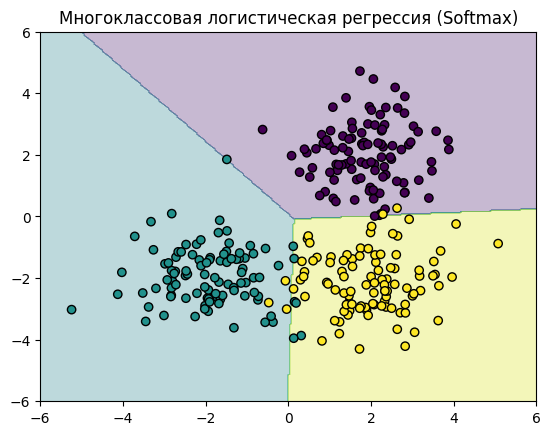

In [55]:
np.random.seed(42)

N = 300
X1 = np.random.randn(N//3, 2) + np.array([2, 2])
X2 = np.random.randn(N//3, 2) + np.array([-2, -2])
X3 = np.random.randn(N//3, 2) + np.array([2, -2])

X = np.vstack([X1, X2, X3])
y = np.array([0]*(N//3) + [1]*(N//3) + [2]*(N//3))

# добавляем bias
X = np.c_[np.ones(X.shape[0]), X]


def softmax(Z):
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def one_hot(y, M):
    Y = np.zeros((len(y), M))
    Y[np.arange(len(y)), y] = 1
    return Y

def train_softmax(X, y, lr=0.1, n_iter=2000):
    N, d = X.shape
    M = len(np.unique(y))
    W = np.zeros((d, M))
    Y = one_hot(y, M)

    for _ in range(n_iter):
        P = softmax(X @ W)
        grad = X.T @ (P - Y)
        W -= lr * grad / N

    return W


W = train_softmax(X, y)

xx, yy = np.meshgrid(
    np.linspace(-6, 6, 300),
    np.linspace(-6, 6, 300)
)

grid = np.c_[np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()]
Z = grid @ W
P = softmax(Z)
pred = np.argmax(P, axis=1)

plt.figure()
plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.3)
plt.scatter(X[:,1], X[:,2], c=y, edgecolor='k')
plt.title("Многоклассовая логистическая регрессия (Softmax)")
plt.show()

### Объяснение классификации в многоклассовой логистической регрессии

В многоклассовой логистической регрессии каждому классу $C_k$ сопоставляется собственный вектор параметров $\omega_k$. Для каждого объекта $x$ вычисляется набор линейных функций:
$$
z_k = \omega_k^T x, \quad k = 1, \ldots, M.
$$

Эти значения представляют собой оценки «уверенности» модели в принадлежности объекта соответствующему классу.

Далее к вектору $(z_1, \ldots, z_M)$ применяется функция `softmax`, которая преобразует линейные оценки в вероятности:
$$
\mathbb P(C_k \mid x)
=
\frac{\exp(z_k)}{\sum_{j=1}^{M} \exp(z_j)}.
$$

Функция `softmax` обладает следующими свойствами:
- все вероятности неотрицательны;
- сумма вероятностей по всем классам равна единице;
- увеличение $z_k$ увеличивает вероятность класса $C_k$ относительно остальных.

Классификация объекта осуществляется по правилу максимальной апостериорной вероятности:
$$
\hat y = \arg\max_{k} \mathbb P(C_k \mid x).
$$

## Вывод

- Классификация осуществляется путём сравнения линейных оценок для всех классов.
- Функция `softmax` преобразует линейные оценки в вероятности.
- Решающее правило соответствует выбору класса с максимальной вероятностью.
- Разделяющие поверхности между классами являются линейными гиперплоскостями.